In [14]:
from glob import glob
from os.path import join
import pandas as pd

In [15]:
import numpy as np
import pickle

def load_pickle_safely(pickle_file):
    with open(pickle_file, 'rb') as f:
        return pickle.load(f)

def maybe_load_pickle(pickle_file):
    try:
        result = load_pickle_safely(pickle_file)
    except Exception:
        return None

def compute_means(draw_dict):
    
    return {x: y.mean(axis=(0, 1)) for x, y in draw_dict.items()}

def compute_sds(draw_dict):
    
    return {x: y.std(axis=(0, 1)) for x, y in draw_dict.items()}

def compute_z_score_mean(mean_dict, ref_mean_dict, ref_sd_dict):
    
    return {x: (mean_dict[x] - ref_mean_dict[x]) / ref_sd_dict[x] for x in mean_dict}

def compute_relative_error_sd(sd_dict, ref_sd_dict):

    return {x: (sd_dict[x] - ref_sd_dict[x]) / ref_sd_dict[x] for x in ref_sd_dict}

def flatten_dict(var_dict, names):

    return np.concatenate([var_dict[x].reshape(-1) for x in names])


In [68]:
from os.path import split, splitext

def load_moment_df(draw_folder):

    model_dicts = glob(join(draw_folder, "draw_dicts", "*.npz"))
    data = pd.DataFrame({"draw_dict_path": model_dicts})

    data["draws"] = data["draw_dict_path"].apply(lambda x: dict(np.load(x)))
    data["means"] = data["draws"].apply(compute_means)
    data["sds"] = data["draws"].apply(compute_sds)

    # No need for the draws any more for now
    data = data.drop(columns="draws")

    # Fetch model name
    data['model_name'] = data['draw_dict_path'].apply(lambda x: splitext(split(x)[-1])[0])

    return data

def check_convergence_sadvi(metadata, max_iter=100000):

    return metadata['steps'] < max_iter


def check_convergence_raabbvi(metadata, max_iter=19900):

    n_steps = metadata['kl_hist_i'].max()

    return n_steps < max_iter


def add_metadata(moment_df, method):

    assert method in ['NUTS', 'RAABBVI', 'DADVI', 'LRVB', 'SADVI', 'SADVI_FR', 'LRVB_Doubling']

    if method in ['RAABBVI', 'DADVI', 'LRVB', 'SADVI', 'SADVI_FR', 'LRVB_Doubling']:
        subdir_lookup = {
            'RAABBVI': 'info',
            'DADVI': 'dadvi_info',
            'LRVB': 'lrvb_info',
            'SADVI': 'info',
            'SADVI_FR': 'info',
            'LRVB_Doubling': 'lrvb_info'
        }
        subdir = subdir_lookup[method]
        moment_df["info_path"] = (
            moment_df["draw_dict_path"]
            .str.replace("draw_dicts", subdir)
            .str.replace(".npz", ".pkl", regex=False)
        )

        moment_df['metadata'] = moment_df['info_path'].apply(load_pickle_safely)
        moment_df['runtime'] = moment_df['metadata'].apply(lambda x: x['runtime'])

        if method.startswith('SADVI'):
            moment_df['converged'] = moment_df['metadata'].apply(check_convergence_sadvi)
        elif method == 'RAABBVI':
            moment_df['converged'] = moment_df['metadata'].apply(check_convergence_raabbvi)

    else:
        # It's NUTS; get runtime:
        moment_df['runtime_path'] = (
            moment_df['draw_dict_path']
            .str.replace('draw_dicts', 'runtimes')
            .str.replace('.npz', '.csv', regex=False)
        )
        moment_df['runtime'] = (
            moment_df['runtime_path']
            .apply(lambda x: pd.read_csv(x)['0'].iloc[0])
        )

        # TODO: get rhat

    return moment_df

from os.path import join

base_folder = '../blade_runs/'

folder_method_list = (
    (join(base_folder, "nuts_results/"), 'NUTS'),
    (join(base_folder, "dadvi_results/"), 'DADVI'),
    (join(base_folder, "lrvb_results/"), 'LRVB'),
    (join(base_folder, "raabbvi_results/"), 'RAABBVI'),
    (join(base_folder, "sadvi_results/"), 'SADVI'),
    (join(base_folder, "sfullrank_advi_results/"), 'SADVI_FR'),
    (join(base_folder, 'lrvb_doubling_results'), 'LRVB_Doubling')
)

all_results = dict()

for cur_folder, cur_method in folder_method_list:

    print(cur_method, cur_folder)

    data = load_moment_df(cur_folder)

    data = add_metadata(data, cur_method)

    all_results[cur_method] = data


NUTS ../blade_runs/nuts_results/
DADVI ../blade_runs/dadvi_results/
LRVB ../blade_runs/lrvb_results/
RAABBVI ../blade_runs/raabbvi_results/
SADVI ../blade_runs/sadvi_results/
SADVI_FR ../blade_runs/sfullrank_advi_results/
LRVB_Doubling ../blade_runs/lrvb_doubling_results


In [69]:
def add_deviation_stats(model_df, reference_df):

    together = model_df.merge(
        reference_df, on="model_name", suffixes=("_model", "_reference")
    )

    together["mean_deviations"] = together.apply(
        lambda x: compute_z_score_mean(
            x["means_model"], x["means_reference"], x["sds_reference"]
        ),
        axis=1,
    )

    together["sd_deviations"] = together.apply(
        lambda x: compute_relative_error_sd(x["sds_model"], x["sds_reference"]), axis=1
    )

    together["var_names"] = together["means_reference"].apply(
        lambda x: sorted(list(x.keys()))
    )


    # Add these to the model stats
    cols_to_keep = [
        "model_name",
        "mean_deviations",
        "sd_deviations",
        "var_names",
    ]

    new_stats = together[cols_to_keep]

    return model_df.merge(new_stats, on='model_name', how='left')


def add_derived_stats(model_df):

    model_df["mean_deviations_flat"] = model_df.apply(
        lambda x: flatten_dict(x["mean_deviations"], x["var_names"]), axis=1
    )

    model_df["sd_deviations_flat"] = model_df.apply(
        lambda x: flatten_dict(x["sd_deviations"], x["var_names"]), axis=1
    )

    model_df['mean_rms'] = model_df['mean_deviations_flat'].apply(lambda x: np.sqrt(np.mean(x**2)))
    model_df['sd_rms'] = model_df['sd_deviations_flat'].apply(lambda x: np.sqrt(np.mean(x**2)))

    return model_df


In [70]:
all_results['SADVI']

,draw_dict_path,means,sds,model_name,info_path,metadata,runtime,converged
0,../blade_runs/sadvi_results/draw_dicts/radon_g...,"{'Intercept': 1.2505417197672661, 'x': [-0.658...","{'Intercept': 0.02730806232966237, 'x': [0.071...",radon_group,../blade_runs/sadvi_results/info/radon_group.pkl,"{'steps': 100000, 'runtime': 21.600921630859375}",21.600922,False
1,../blade_runs/sadvi_results/draw_dicts/occ_det...,"{'w_env': [[0.1658606011225259, -0.03987874096...","{'w_env': [[1.0288546120487498, 1.039400766953...",occ_det,../blade_runs/sadvi_results/info/occ_det.pkl,"{'steps': 100000, 'runtime': 1076.2247185707092}",1076.224719,False
2,../blade_runs/sadvi_results/draw_dicts/wells_i...,"{'Intercept': 0.33733751688907193, 'dist100': ...","{'Intercept': 0.0422863915229066, 'dist100': [...",wells_interaction,../blade_runs/sadvi_results/info/wells_interac...,"{'steps': 100000, 'runtime': 29.87992238998413}",29.879922,False
3,../blade_runs/sadvi_results/draw_dicts/logearn...,"{'Intercept': 9.712446301040425, 'height': [0....","{'Intercept': 0.03022450233190752, 'height': [...",logearn_height,../blade_runs/sadvi_results/info/logearn_heigh...,"{'steps': 46199, 'runtime': 5.917670249938965}",5.917670,True
4,../blade_runs/sadvi_results/draw_dicts/wells_d...,"{'Intercept': 0.3399103044706485, 'c_dist100':...","{'Intercept': 0.04255129389429329, 'c_dist100'...",wells_dae_c,../blade_runs/sadvi_results/info/wells_dae_c.pkl,"{'steps': 100000, 'runtime': 31.49224543571472}",31.492245,False
5,../blade_runs/sadvi_results/draw_dicts/sesame_...,"{'Intercept': 26.72985845472546, 'encouraged':...","{'Intercept': 1.0099293284691508, 'encouraged'...",sesame_one_pred_b,../blade_runs/sadvi_results/info/sesame_one_pr...,"{'steps': 36399, 'runtime': 4.864454984664917}",4.864455,True
6,../blade_runs/sadvi_results/draw_dicts/test_rs...,"{'Intercept': -0.7015216744302136, 'x': [2.539...","{'Intercept': 0.003570904044275687, 'x': [0.00...",test_rstanarm,../blade_runs/sadvi_results/info/test_rstanarm...,"{'steps': 100000, 'runtime': 26.469897747039795}",26.469898,False
7,../blade_runs/sadvi_results/draw_dicts/mesquit...,"{'Intercept': 5.9180697304648975, 'np.log(I(di...","{'Intercept': 0.056743846554802094, 'np.log(I(...",mesquite_va,../blade_runs/sadvi_results/info/mesquite_va.pkl,"{'steps': 100000, 'runtime': 11.415233612060547}",11.415234,False
8,../blade_runs/sadvi_results/draw_dicts/radon_i...,"{'Intercept': 1.305624429308612, '1|county_off...","{'Intercept': 0.029535601570931144, '1|county_...",radon_intercept,../blade_runs/sadvi_results/info/radon_interce...,"{'steps': 100000, 'runtime': 13.50944471359253}",13.509445,False
9,../blade_runs/sadvi_results/draw_dicts/wells_d...,"{'Intercept': 0.33708627317667106, 'c_dist100'...","{'Intercept': 0.04353073982945113, 'c_dist100'...",wells_daae_c,../blade_runs/sadvi_results/info/wells_daae_c.pkl,"{'steps': 100000, 'runtime': 31.845603942871094}",31.845604,False


In [99]:
raabbvi_maxiter = 19900

method_1 = 'LRVB_Doubling'
method_2 = 'RAABBVI'

method_1_df = add_deviation_stats(all_results[method_1], all_results['NUTS']).dropna()
method_1_df = add_derived_stats(method_1_df)

method_2_df = add_deviation_stats(all_results[method_2], all_results['NUTS']).dropna()
method_2_df = add_derived_stats(method_2_df)


In [100]:
all_results['SADVI']['converged'].mean()

0.25862068965517243

In [101]:
comparison = method_1_df.merge(method_2_df, on='model_name', 
                                         suffixes=(f'_{method_1}', f'_{method_2}'))

comparison

,draw_dict_path_LRVB_Doubling,means_LRVB_Doubling,sds_LRVB_Doubling,model_name,info_path_LRVB_Doubling,metadata_LRVB_Doubling,runtime_LRVB_Doubling,mean_deviations_LRVB_Doubling,sd_deviations_LRVB_Doubling,var_names_LRVB_Doubling,...,metadata_RAABBVI,runtime_RAABBVI,converged,mean_deviations_RAABBVI,sd_deviations_RAABBVI,var_names_RAABBVI,mean_deviations_flat_RAABBVI,sd_deviations_flat_RAABBVI,mean_rms_RAABBVI,sd_rms_RAABBVI
0,../blade_runs/lrvb_doubling_results/draw_dicts...,"{'Intercept': 1.2462011084758364, 'x': [-0.624...","{'Intercept': 0.03820827237359404, 'x': [0.076...",radon_group,../blade_runs/lrvb_doubling_results/lrvb_info/...,{'opt_result': {'opt_result': {'x': [-0.278567...,1.982486,"{'Intercept': -0.3072318189192549, 'x': [0.635...","{'Intercept': 0.007468135403422652, 'x': [0.11...","[1|county, 1|county_offset, 1|county_sigma, In...",...,"{'opt_result': [-0.1250025698087124, 0.1026089...",28.921525,True,"{'Intercept': -0.02178846346005501, 'x': [0.03...","{'Intercept': -0.30294099195281254, 'x': [-0.0...","[1|county, 1|county_offset, 1|county_sigma, In...","[0.021794104142021837, 0.08801203149354617, -0...","[-0.11528252856402486, -0.15682885388164, -0.0...",0.055675,0.085393
1,../blade_runs/lrvb_doubling_results/draw_dicts...,"{'w_env': [[0.06199805740214316, -0.2216131989...","{'w_env': [[0.9964835743117384, 1.036748947751...",occ_det,../blade_runs/lrvb_doubling_results/lrvb_info/...,{'opt_result': {'opt_result': {'x': [11.898528...,3231.954773,"{'w_env': [[-0.38875603744782605, 0.0338387673...","{'w_env': [[0.031790767595044685, 0.0215889054...","[intercept, w_env, w_obs, w_obs_raw, w_prior_m...",...,"{'opt_result': [13.27675285426697, -2.02322672...",10934.805781,False,"{'w_env': [[-0.38566566703709515, 0.1843631570...","{'w_env': [[0.009284759270029447, -0.004035249...","[intercept, w_env, w_obs, w_obs_raw, w_prior_m...","[1.8586776673504635, -0.036896917393699005, 0....","[-0.5302020958332799, -0.654951399083353, -0.6...",0.325106,0.349005
2,../blade_runs/lrvb_doubling_results/draw_dicts...,"{'Intercept': 0.3855838297725428, 'dist100': [...","{'Intercept': 0.052777589322301414, 'dist100':...",wells_interaction,../blade_runs/lrvb_doubling_results/lrvb_info/...,{'opt_result': {'opt_result': {'x': [ 0.384339...,1.243284,"{'Intercept': 1.2203734052230384, 'dist100': [...","{'Intercept': 0.3816614495111961, 'dist100': [...","[Intercept, arsenic, dist100, dist100:arsenic]",...,"{'opt_result': [0.3380013332657113, 0.55664870...",65.747340,True,"{'Intercept': -0.0069819684815609455, 'dist100...","{'Intercept': 0.04416431655704045, 'dist100': ...","[Intercept, arsenic, dist100, dist100:arsenic]","[-0.0069819684815609455, -0.09105933835621306,...","[0.04416431655704045, -0.42362559095374913, -0...",0.047205,0.466840
3,../blade_runs/lrvb_doubling_results/draw_dicts...,"{'Intercept': 9.71527389166385, 'height': [0.0...","{'Intercept': 0.02640884832008108, 'height': [...",logearn_height,../blade_runs/lrvb_doubling_results/lrvb_info/...,{'opt_result': {'opt_result': {'x': [ 9.716632...,1.230621,"{'Intercept': 0.019223743443567847, 'height': ...","{'Intercept': 0.031694287570932476, 'height': ...","[Intercept, height, np.log(earn)_sigma]",...,"{'opt_result': [9.714324720549236, 0.058813001...",11.494843,True,"{'Intercept': -0.07062133131834827, 'height': ...","{'Intercept': 0.029481634952784358, 'height': ...","[Intercept, height, np.log(earn)_sigma]","[-0.07062133131834827, -0.006184088158191111, ...","[0.029481634952784358, -0.02577680773504953, 0...",0.050698,0.029635
4,../blade_runs/lrvb_doubling_results/draw_dicts...,"{'Intercept': 0.3493705547966898, 'c_dist100':...","{'Intercept': 0.03938706969290658, 'c_dist100'...",wells_dae_c,../blade_runs/lrvb_doubling_results/lrvb_info/...,{'opt_result': {'opt_result': {'x': [ 0.350191...,1.389701,"{'Intercept': 0.1739736794033759, 'c_dist100':...","{'Intercept': 0.009247764618570633, 'c_dist100...","[Intercept, c_arsenic, c_dist100, c_dist100:c_...",...,"{'opt_result': [0.3

In [102]:
raabvi_with_deviations.iloc[0]['metadata'].keys()

dict_keys(['opt_result', 'kl_hist', 'kl_hist_i', 'runtime'])

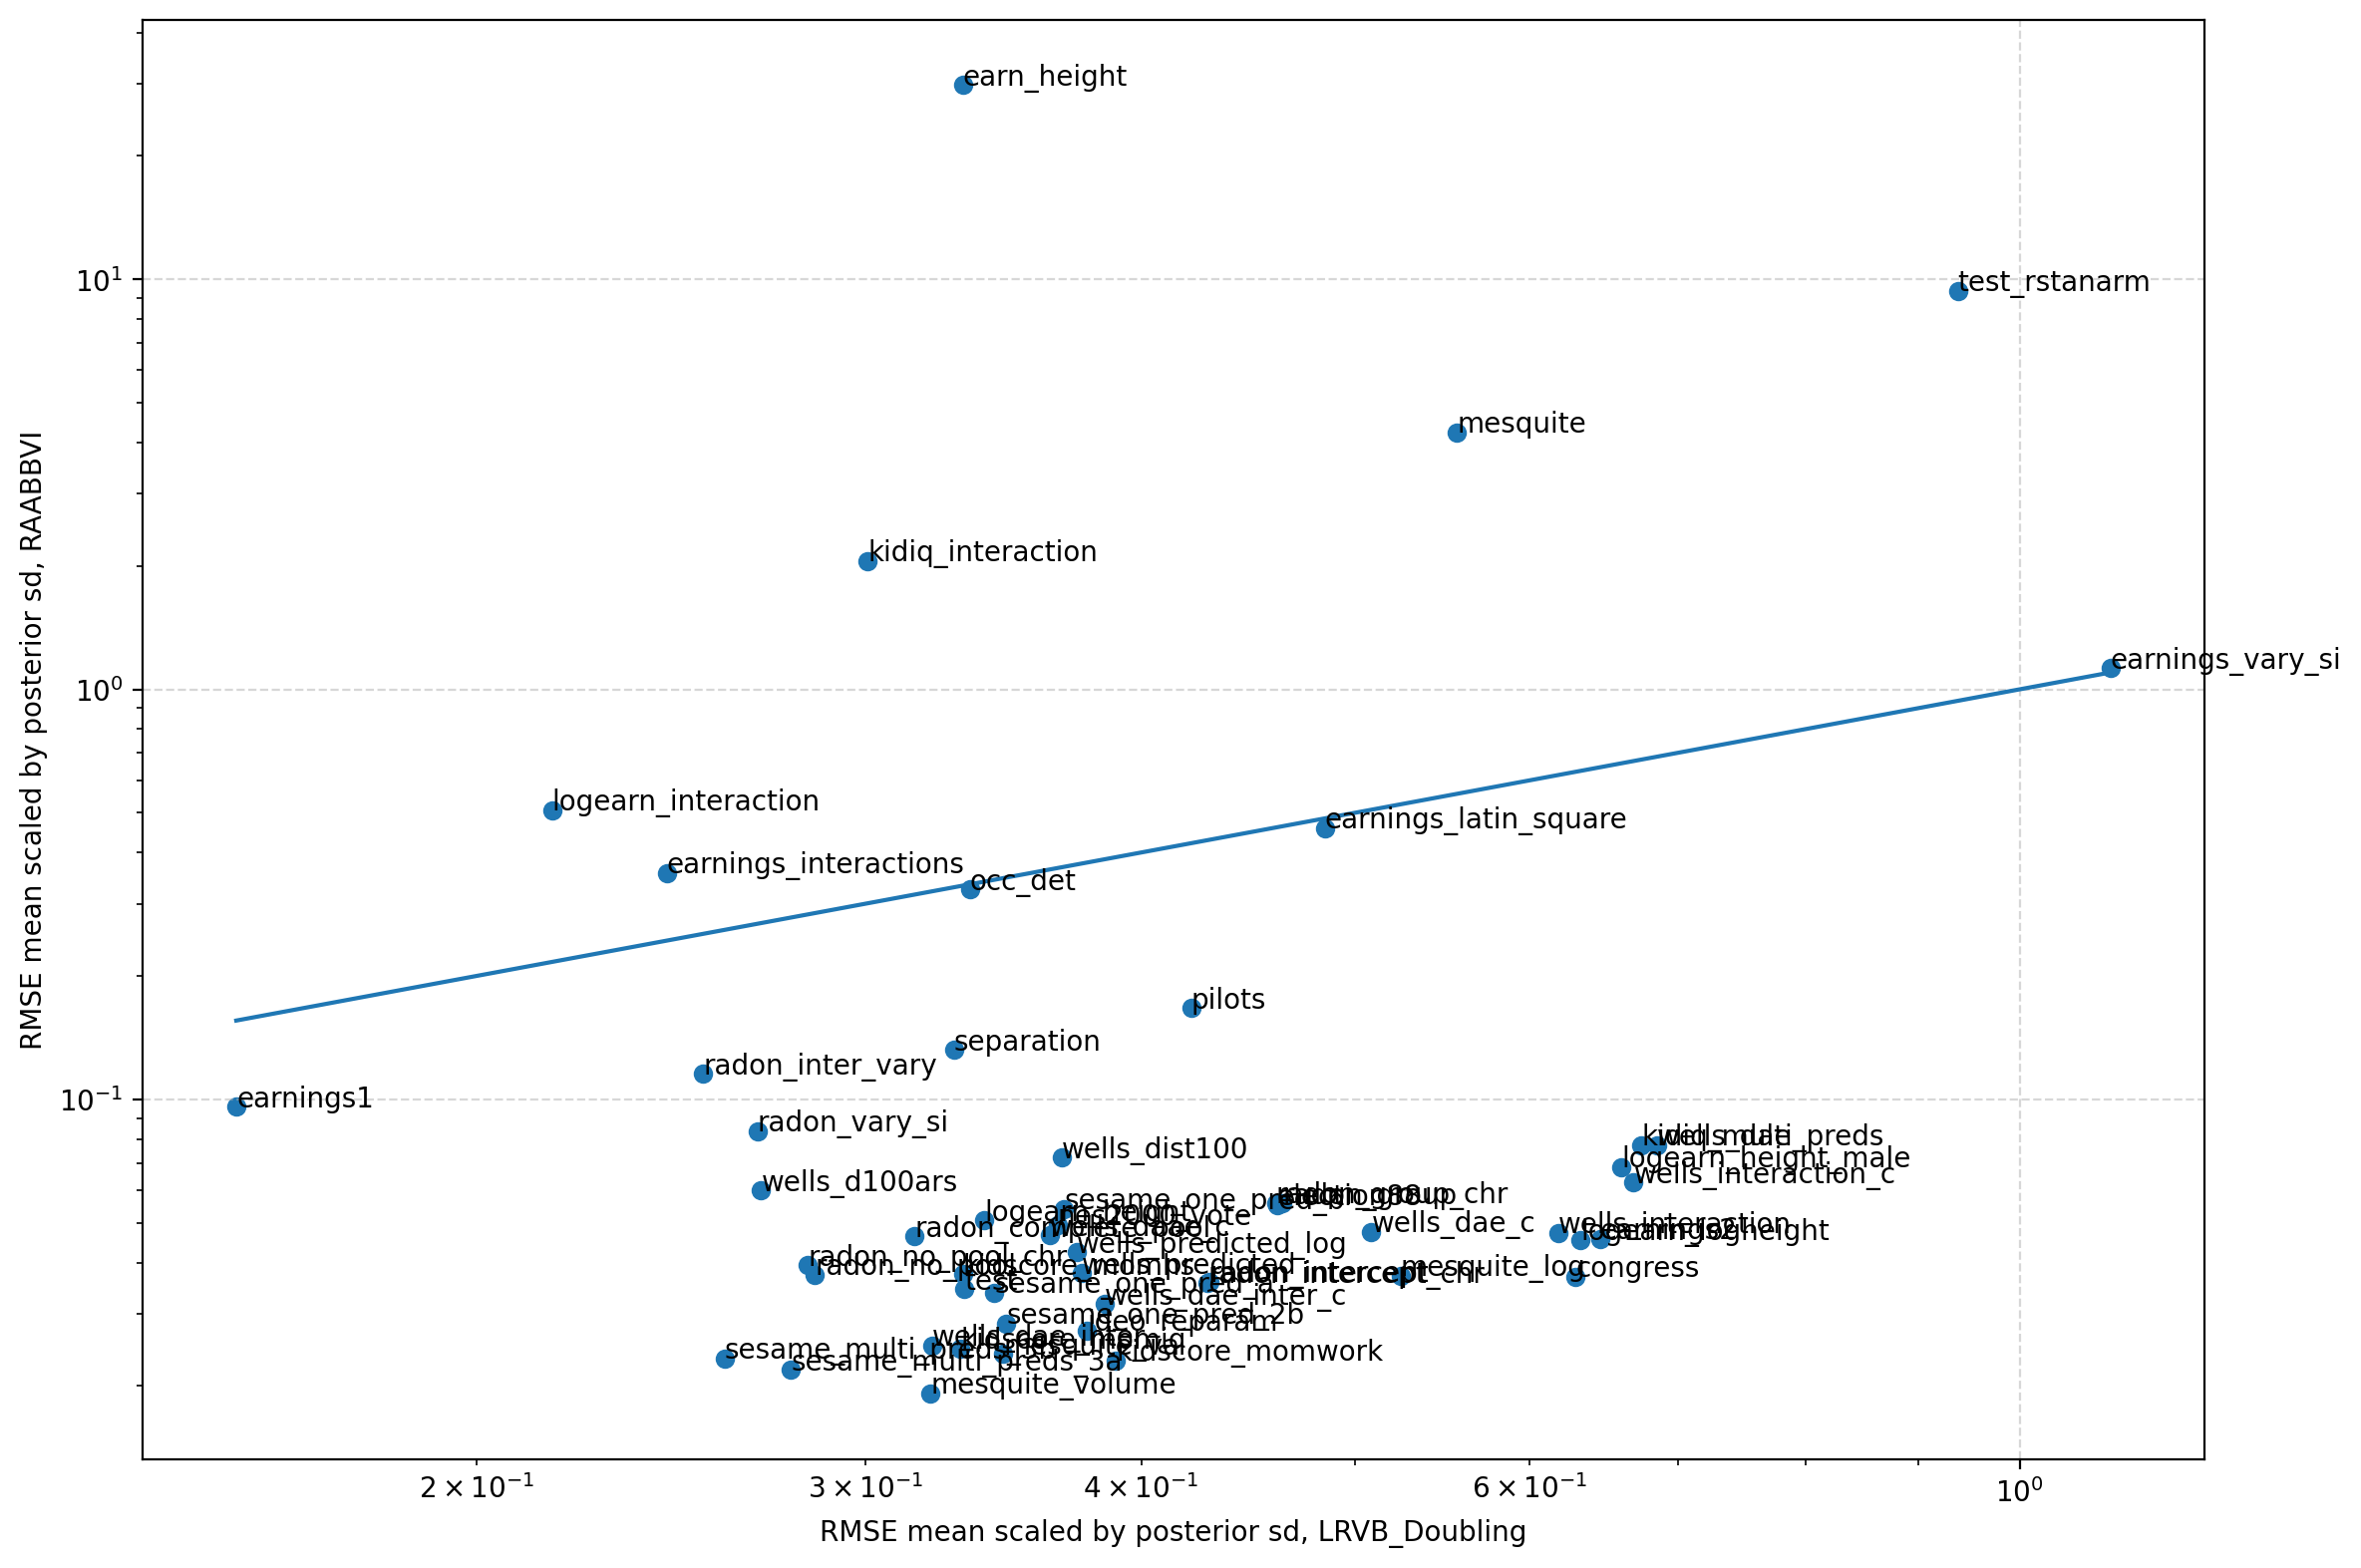

In [103]:
import matplotlib.pyplot as plt

f, ax = plt.subplots(1, 1)

xmin, xmax = [comparison[f'mean_rms_{method_1}'].min(), comparison[f'mean_rms_{method_1}'].max()]
# ax.scatter(comparison['mean_rms_raabbvi'], comparison['mean_rms_lrvb'], c=comparison['converged'])
ax.scatter(comparison[f'mean_rms_{method_1}'], comparison[f'mean_rms_{method_2}'])
ax.plot([xmin, xmax], [xmin, xmax])

for row in comparison.itertuples():
    ax.annotate(row.model_name, (getattr(row, f'mean_rms_{method_1}'), getattr(row, f'mean_rms_{method_2}')))

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(f'RMSE mean scaled by posterior sd, {method_1}')
ax.set_ylabel(f'RMSE mean scaled by posterior sd, {method_2}')

ax.grid(alpha=0.5, linestyle='--')

f.set_size_inches(12, 8)
f.tight_layout()

# plt.savefig('./mean_comparison.png', dpi=300)


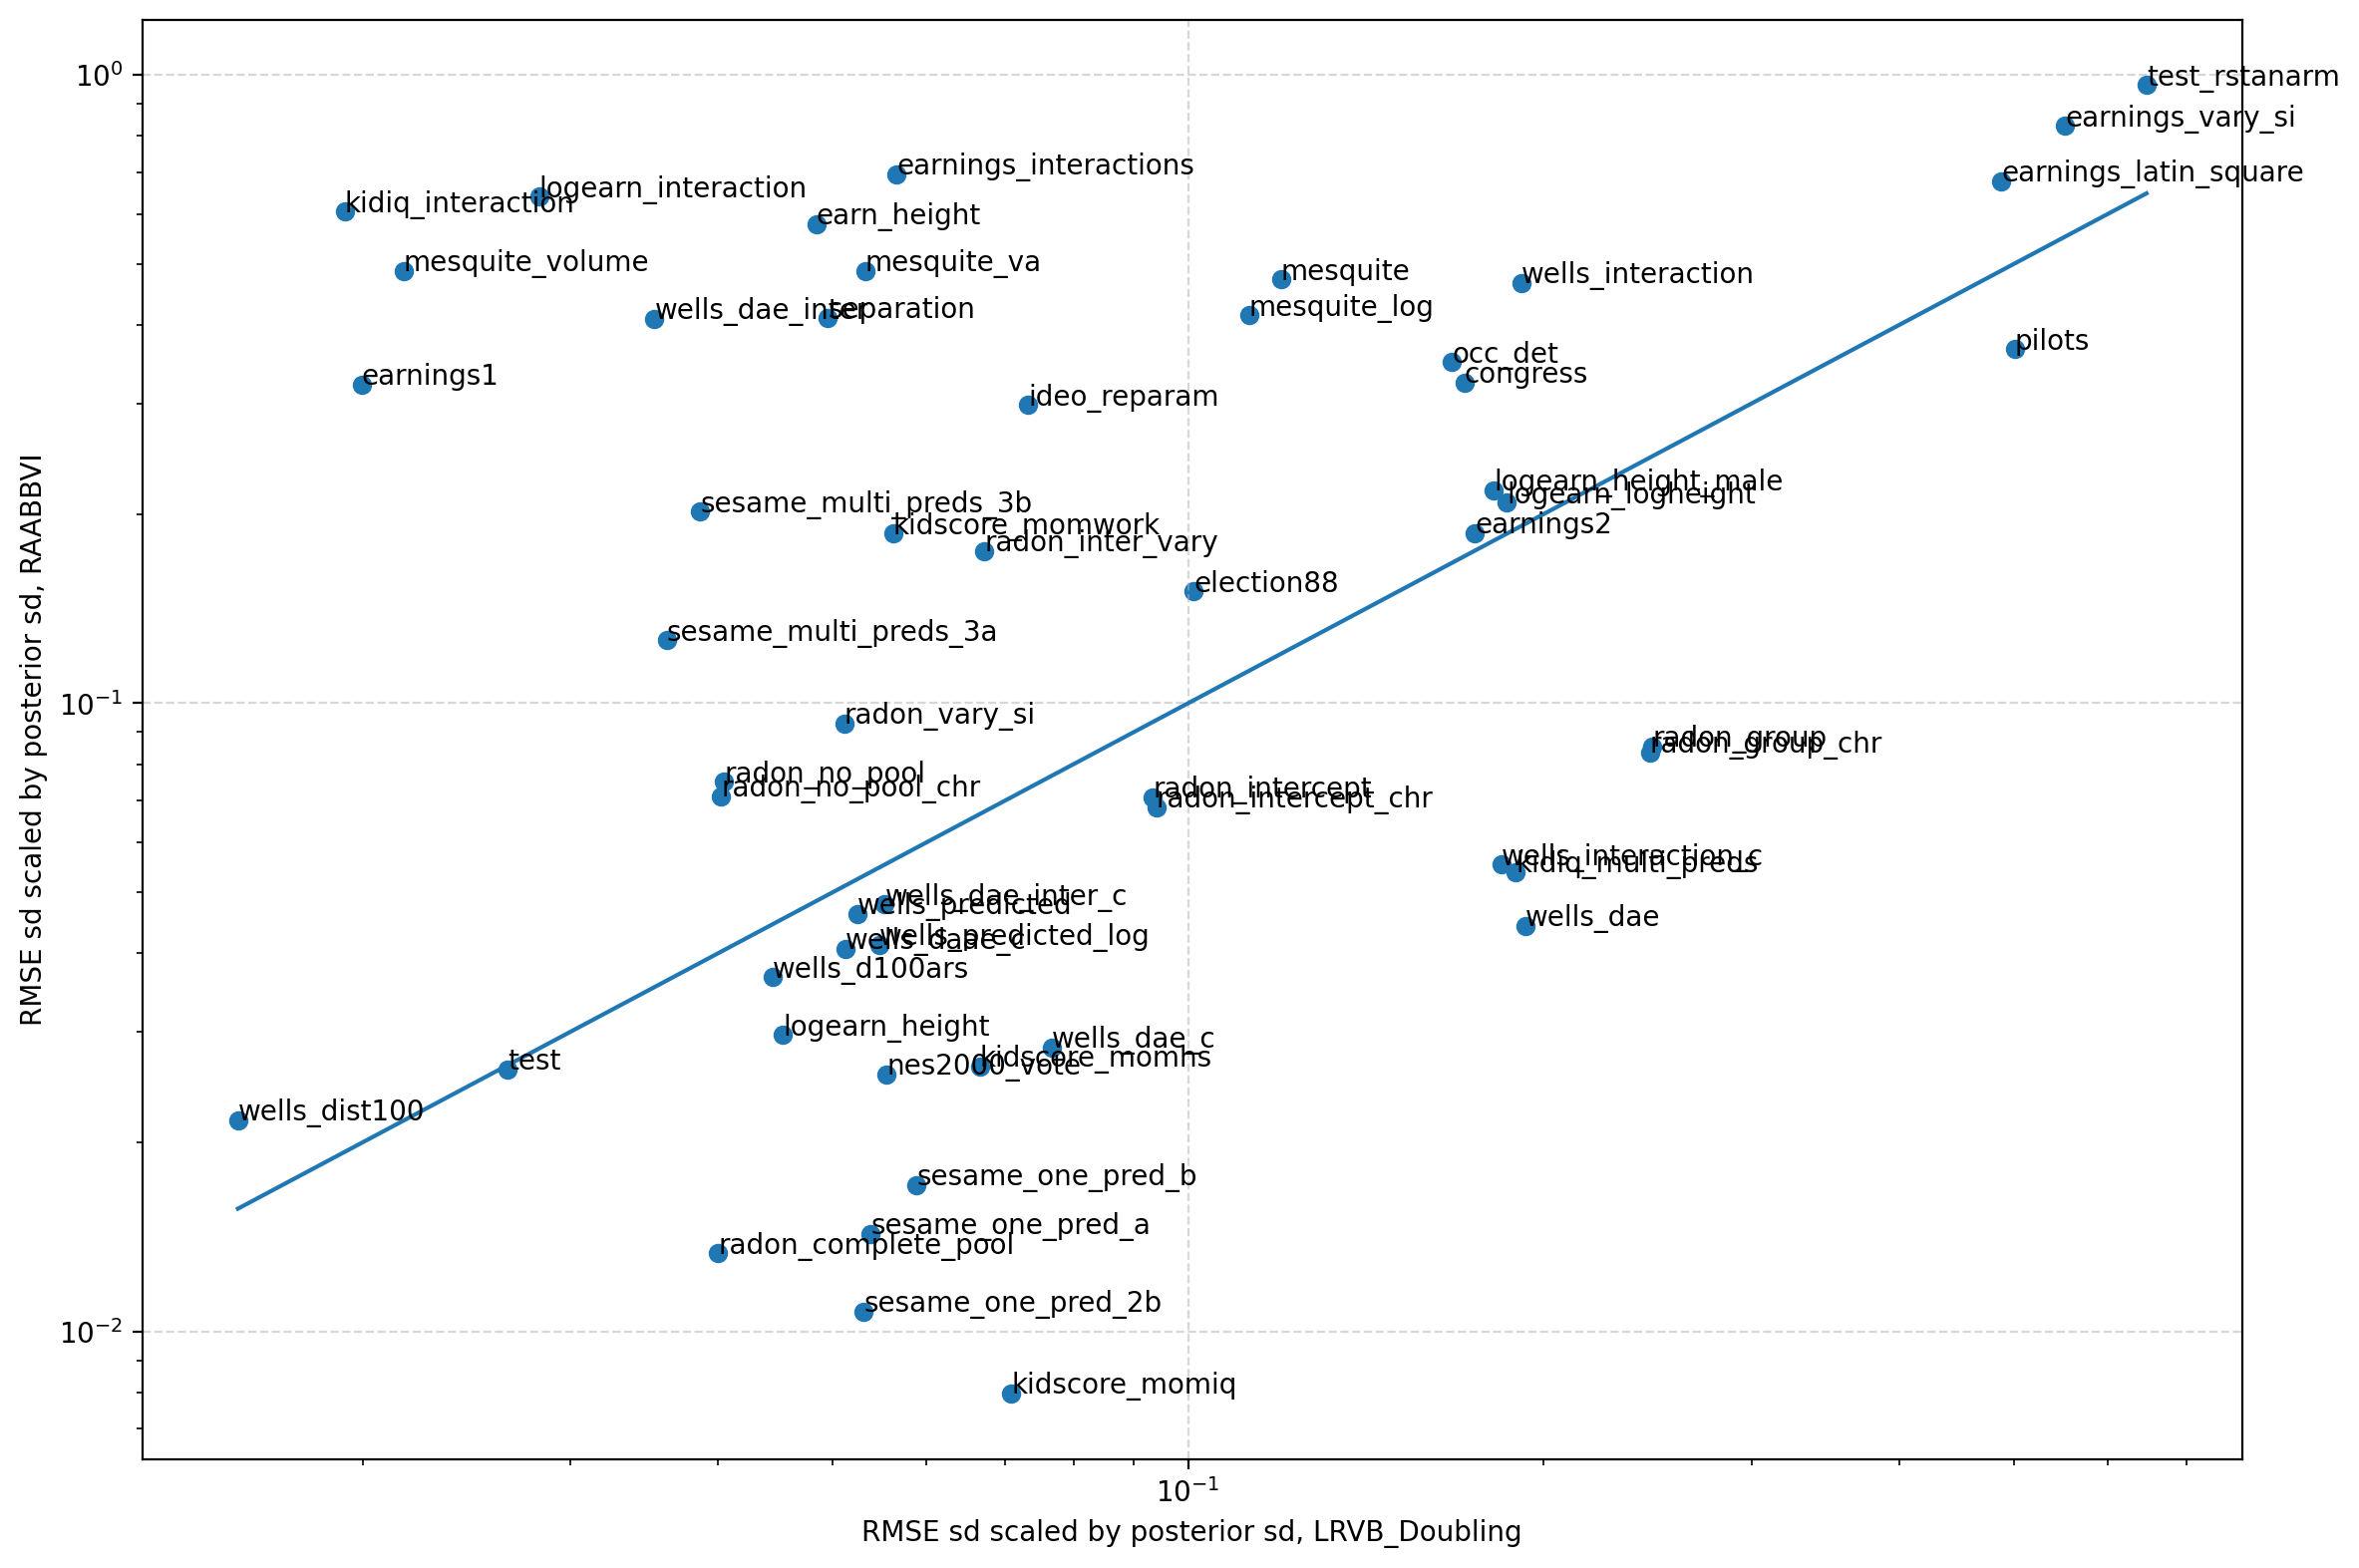

In [104]:
f, ax = plt.subplots(1, 1)

xmin, xmax = [comparison[f'sd_rms_{method_1}'].min(), comparison[f'sd_rms_{method_1}'].max()]
# ax.scatter(comparison['mean_rms_raabbvi'], comparison['mean_rms_lrvb'], c=comparison['converged'])
ax.scatter(comparison[f'sd_rms_{method_1}'], comparison[f'sd_rms_{method_2}'])
ax.plot([xmin, xmax], [xmin, xmax])

for row in comparison.itertuples():
    ax.annotate(row.model_name, (getattr(row, f'sd_rms_{method_1}'), getattr(row, f'sd_rms_{method_2}')))

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(f'RMSE sd scaled by posterior sd, {method_1}')
ax.set_ylabel(f'RMSE sd scaled by posterior sd, {method_2}')

ax.grid(alpha=0.5, linestyle='--')

f.set_size_inches(12, 8)
f.tight_layout()

# plt.savefig('./sd_comparison.png', dpi=300)

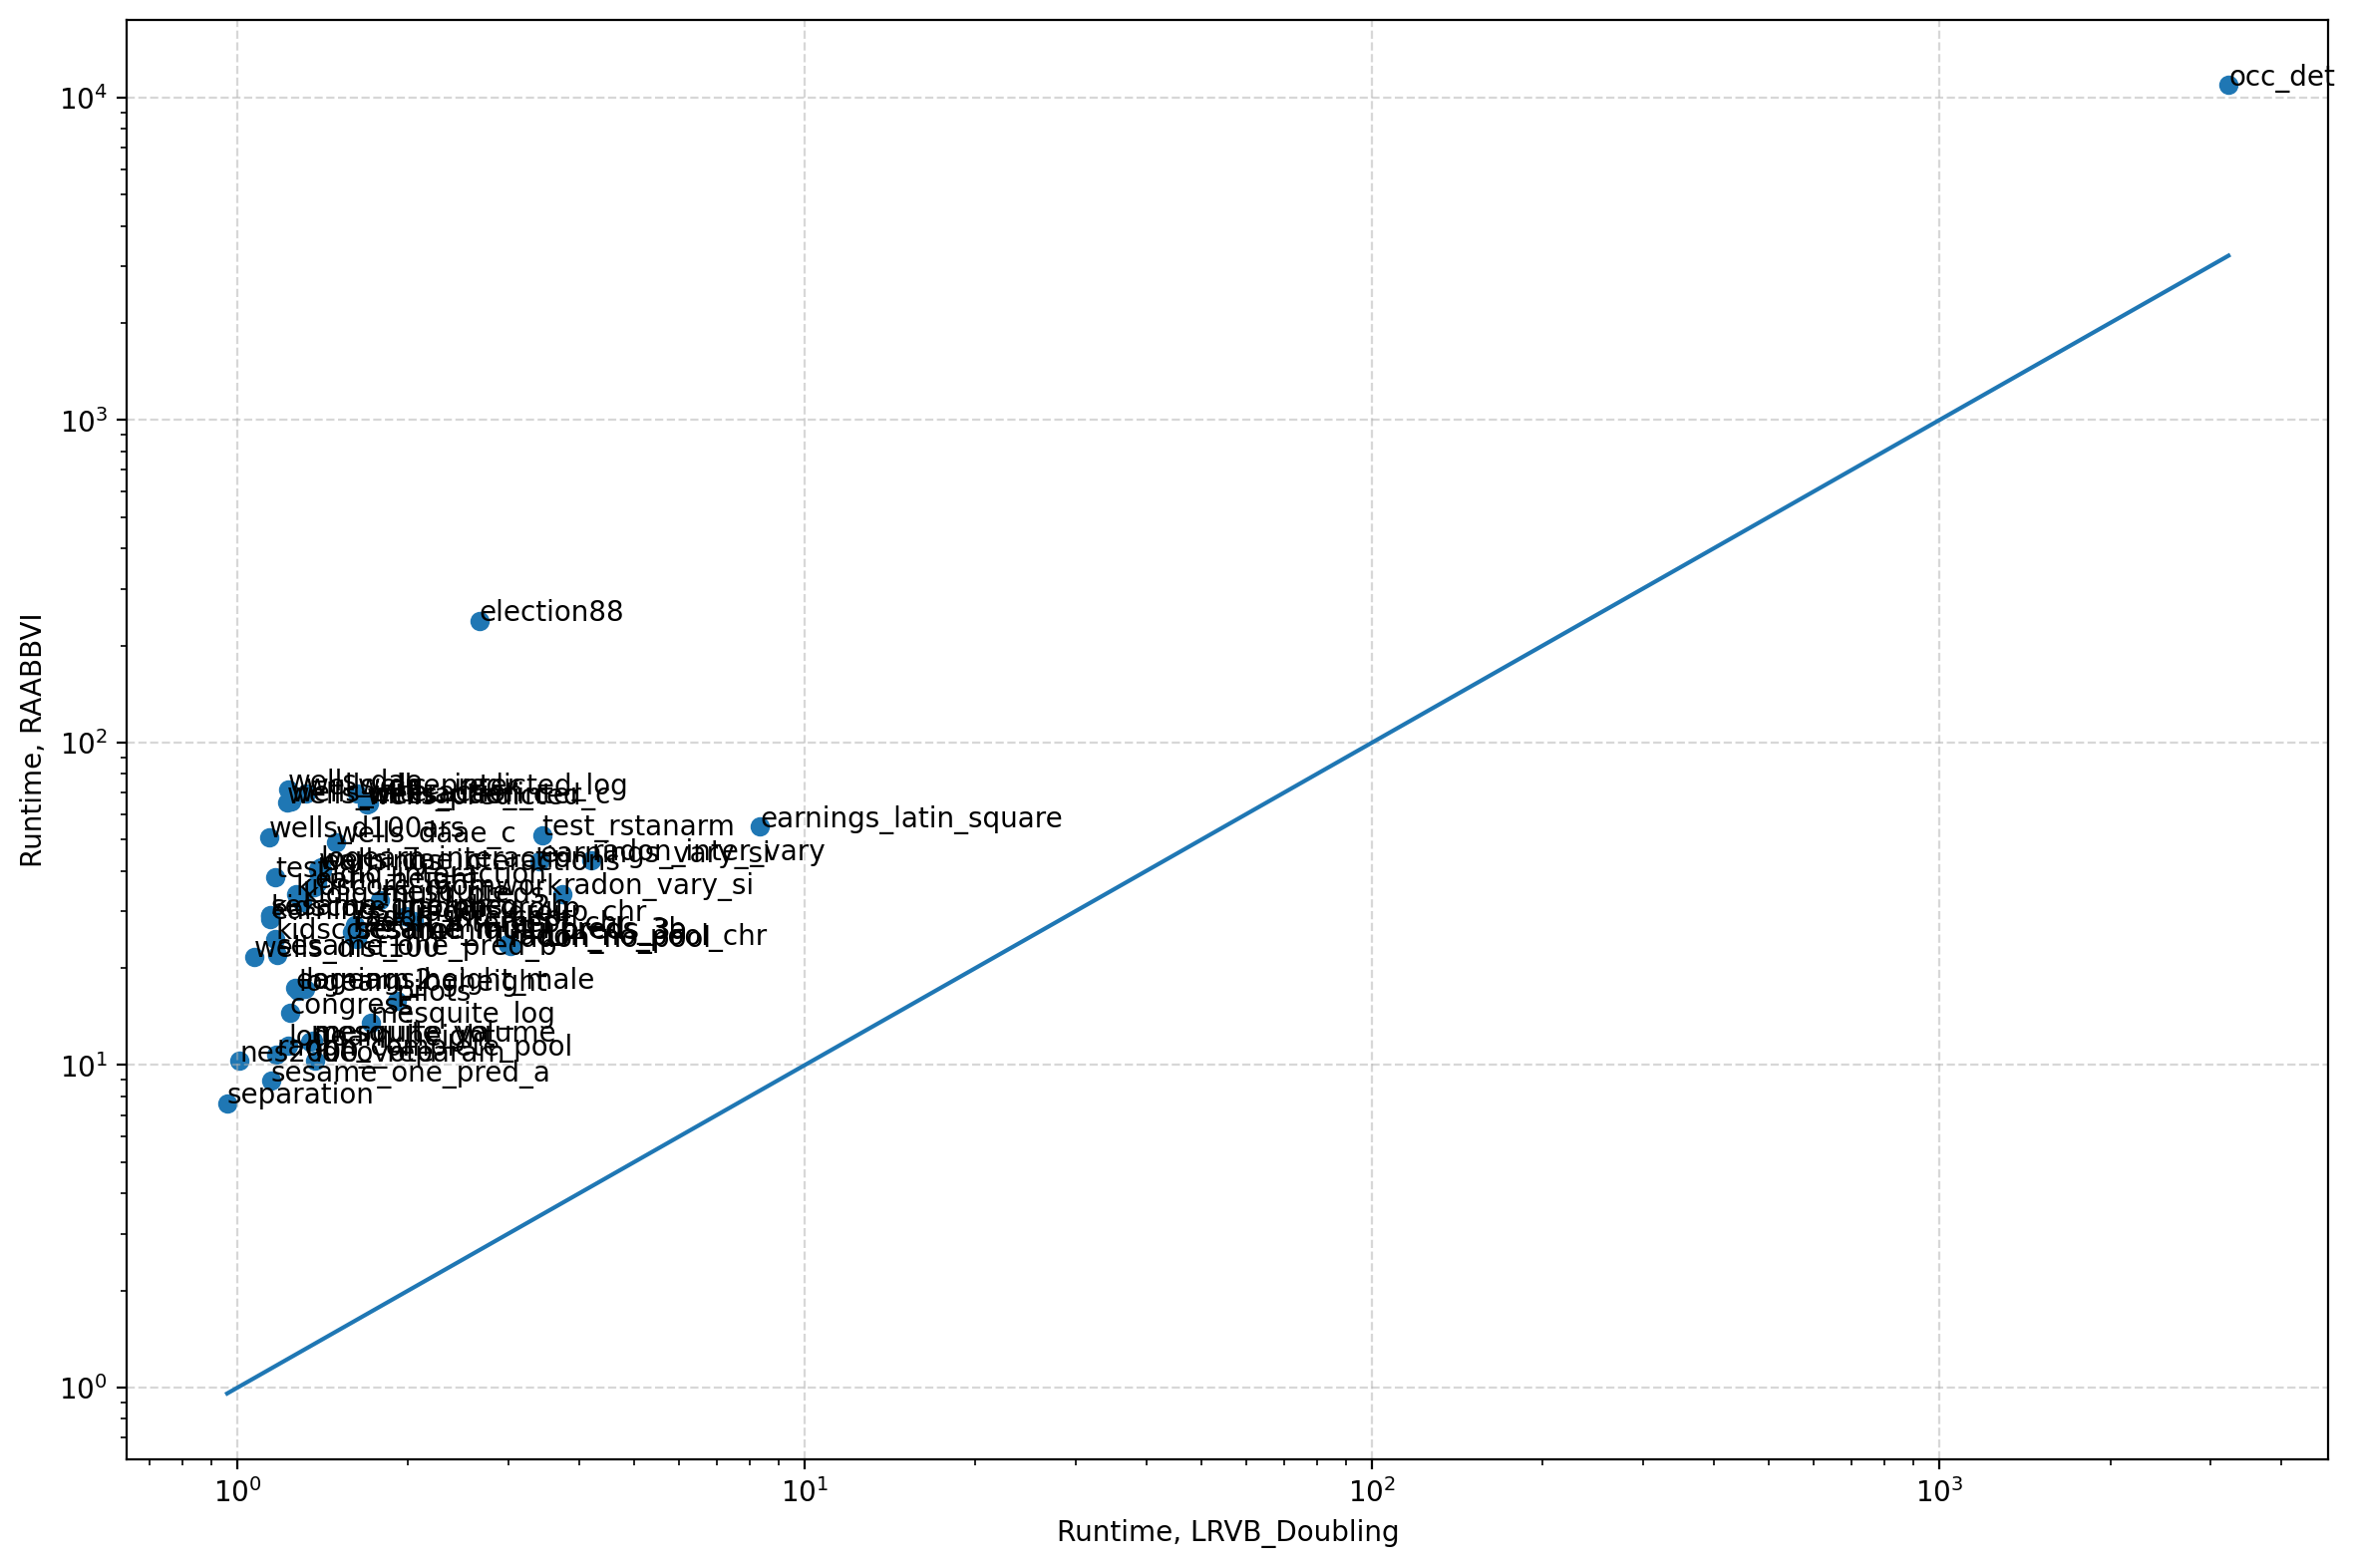

In [106]:

f, ax = plt.subplots(1, 1)

xmin, xmax = [comparison[f'runtime_{method_1}'].min(), comparison[f'runtime_{method_1}'].max()]
# ax.scatter(comparison['mean_rms_raabbvi'], comparison['mean_rms_lrvb'], c=comparison['converged'])
ax.scatter(comparison[f'runtime_{method_1}'], comparison[f'runtime_{method_2}'])
ax.plot([xmin, xmax], [xmin, xmax])

for row in comparison.itertuples():
    ax.annotate(row.model_name, (getattr(row, f'runtime_{method_1}'), getattr(row, f'runtime_{method_2}')))

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_xlabel(f'Runtime, {method_1}')
ax.set_ylabel(f'Runtime, {method_2}')

ax.grid(alpha=0.5, linestyle='--')

f.set_size_inches(12, 8)
f.tight_layout()

# plt.savefig('runtime_comparison.png', dpi=300)

In [107]:
comparison.head()

,draw_dict_path_LRVB_Doubling,means_LRVB_Doubling,sds_LRVB_Doubling,model_name,info_path_LRVB_Doubling,metadata_LRVB_Doubling,runtime_LRVB_Doubling,mean_deviations_LRVB_Doubling,sd_deviations_LRVB_Doubling,var_names_LRVB_Doubling,...,metadata_RAABBVI,runtime_RAABBVI,converged,mean_deviations_RAABBVI,sd_deviations_RAABBVI,var_names_RAABBVI,mean_deviations_flat_RAABBVI,sd_deviations_flat_RAABBVI,mean_rms_RAABBVI,sd_rms_RAABBVI
0,../blade_runs/lrvb_doubling_results/draw_dicts...,"{'Intercept': 1.2462011084758364, 'x': [-0.624...","{'Intercept': 0.03820827237359404, 'x': [0.076...",radon_group,../blade_runs/lrvb_doubling_results/lrvb_info/...,{'opt_result': {'opt_result': {'x': [-0.278567...,1.982486,"{'Intercept': -0.3072318189192549, 'x': [0.635...","{'Intercept': 0.007468135403422652, 'x': [0.11...","[1|county, 1|county_offset, 1|county_sigma, In...",...,"{'opt_result': [-0.1250025698087124, 0.1026089...",28.921525,True,"{'Intercept': -0.02178846346005501, 'x': [0.03...","{'Intercept': -0.30294099195281254, 'x': [-0.0...","[1|county, 1|county_offset, 1|county_sigma, In...","[0.021794104142021837, 0.08801203149354617, -0...","[-0.11528252856402486, -0.15682885388164, -0.0...",0.055675,0.085393
1,../blade_runs/lrvb_doubling_results/draw_dicts...,"{'w_env': [[0.06199805740214316, -0.2216131989...","{'w_env': [[0.9964835743117384, 1.036748947751...",occ_det,../blade_runs/lrvb_doubling_results/lrvb_info/...,{'opt_result': {'opt_result': {'x': [11.898528...,3231.954773,"{'w_env': [[-0.38875603744782605, 0.0338387673...","{'w_env': [[0.031790767595044685, 0.0215889054...","[intercept, w_env, w_obs, w_obs_raw, w_prior_m...",...,"{'opt_result': [13.27675285426697, -2.02322672...",10934.805781,False,"{'w_env': [[-0.38566566703709515, 0.1843631570...","{'w_env': [[0.009284759270029447, -0.004035249...","[intercept, w_env, w_obs, w_obs_raw, w_prior_m...","[1.8586776673504635, -0.036896917393699005, 0....","[-0.5302020958332799, -0.654951399083353, -0.6...",0.325106,0.349005
2,../blade_runs/lrvb_doubling_results/draw_dicts...,"{'Intercept': 0.3855838297725428, 'dist100': [...","{'Intercept': 0.052777589322301414, 'dist100':...",wells_interaction,../blade_runs/lrvb_doubling_results/lrvb_info/...,{'opt_result': {'opt_result': {'x': [ 0.384339...,1.243284,"{'Intercept': 1.2203734052230384, 'dist100': [...","{'Intercept': 0.3816614495111961, 'dist100': [...","[Intercept, arsenic, dist100, dist100:arsenic]",...,"{'opt_result': [0.3380013332657113, 0.55664870...",65.747340,True,"{'Intercept': -0.0069819684815609455, 'dist100...","{'Intercept': 0.04416431655704045, 'dist100': ...","[Intercept, arsenic, dist100, dist100:arsenic]","[-0.0069819684815609455, -0.09105933835621306,...","[0.04416431655704045, -0.42362559095374913, -0...",0.047205,0.466840
3,../blade_runs/lrvb_doubling_results/draw_dicts...,"{'Intercept': 9.71527389166385, 'height': [0.0...","{'Intercept': 0.02640884832008108, 'height': [...",logearn_height,../blade_runs/lrvb_doubling_results/lrvb_info/...,{'opt_result': {'opt_result': {'x': [ 9.716632...,1.230621,"{'Intercept': 0.019223743443567847, 'height': ...","{'Intercept': 0.031694287570932476, 'height': ...","[Intercept, height, np.log(earn)_sigma]",...,"{'opt_result': [9.714324720549236, 0.058813001...",11.494843,True,"{'Intercept': -0.07062133131834827, 'height': ...","{'Intercept': 0.029481634952784358, 'height': ...","[Intercept, height, np.log(earn)_sigma]","[-0.07062133131834827, -0.006184088158191111, ...","[0.029481634952784358, -0.02577680773504953, 0...",0.050698,0.029635
4,../blade_runs/lrvb_doubling_results/draw_dicts...,"{'Intercept': 0.3493705547966898, 'c_dist100':...","{'Intercept': 0.03938706969290658, 'c_dist100'...",wells_dae_c,../blade_runs/lrvb_doubling_results/lrvb_info/...,{'opt_result': {'opt_result': {'x': [ 0.350191...,1.389701,"{'Intercept': 0.1739736794033759, 'c_dist100':...","{'Intercept': 0.009247764618570633, 'c_dist100...","[Intercept, c_arsenic, c_dist100, c_dist100:c_...",...,"{'opt_result': [0.3

In [110]:
all_results['LRVB_Doubling']['M'] = all_results['LRVB_Doubling']['metadata'].apply(lambda x: x['M'])

In [111]:
all_results['LRVB_Doubling'][['model_name', 'runtime', 'M']].sort_values('M', ascending=False).head(20)

,model_name,runtime,M
1,occ_det,3231.954773,32
65,radon_no_pool,3.024529,16
55,earnings_vary_si,3.405931,16
22,radon_no_pool_chr,2.992355,16
23,radon_inter_vary,4.206867,16
24,electric_1b,3.150043,16
43,microcredit,223.024403,16
54,hiv_inter,3.885435,16
56,radon_vary_si,3.738899,16
58,earnings_latin_square,8.337828,16


In [112]:
all_results['LRVB'][['model_name', 'runtime']].sort_values('runtime')

,model_name,runtime
25,separation,0.768533
40,nes2000_vote,0.794957
23,wells_dist100,0.881234
34,wells_d100ars,0.914805
12,earnings1,0.994757
26,radon_complete_pool,0.998916
24,test,1.026237
10,sesame_one_pred_a,1.041474
5,sesame_one_pred_b,1.043829
44,wells_dae,1.046968
